# Lecture 3 - Discrete Inverse Problems and Regularisation

Given $f^\delta \in \mathbb{R}^m$, find $u \in \mathbb{R}^n$ such that 

$$
Ku = f^\delta,
$$

where $K\in \mathbb{R}^{m\times n}$ is the *forward operator*.

# Well-posedness

## Existence

We need $f^\delta \in \text{range}(K)$

## Uniqueness
We need the null-space of $K$ to be empty

## Stability

The condition number $\kappa(K) = \|K\|\|K^{-1}\|$ determines how errors are amplified 

$$\frac{\|u - v\|}{\|u\|} \leq \kappa(K) \frac{\|f - g\|}{\|f\|},$$

with $Ku = f$ and $Kv = g$.

We can define the condition number for any norm, e.g.

$$\kappa_2(K) = \sigma_1/\sigma_k,$$ 

with $k = \text{rank}(K)$.

# Pseudo-Inverse

## Singular value decomposition

$$K = U\Sigma V^*$$

**Moore-Penrose pseudo-inverse**

$$K^\dagger = V_k \Sigma_k^{-1} U_k^*,$$

with $U_k,\Sigma_k,V_k$ containing the first $k = \text{rank}(K)$ singular vectors and values of $K$.

For $m > n$ and $\text{rank}(K) = n$:

$$K^\dagger = (K^*\!K)^{-1}K^*,$$

and $\widetilde{u} = K^\dagger\!f^\delta$ solves the *least-squares problem*

$$\min_u \|Ku - f^\delta\|_2.$$

Note that here, $K^\dagger$ is a *left inverse* $K^\dagger K = I$

For $m < n$ and $\text{rank}(K) = m$:

$$K^\dagger = K(KK^*)^{-1},$$

and $\widetilde{u} = K^\dagger\!f^\delta$ solves

$$\min_u \|u\|_2 \quad \text{s.t.} \quad Ku = f^\delta$$

Note that here, $K^\dagger$ is a *right inverse* $K K^\dagger = I$

In general, the pseudo-inverse gives the solution with smallest residual and the smallest norm.

# The discrete Picard condition



The solution is given by

$$\widetilde{u} = K^\dagger\! f^\delta = \sum_{i=1}^k \frac{\langle u_i, f^\delta\rangle}{\sigma_i}v_i.$$

It follows that

$$\|\widetilde{u}\|_2^2 = \sum_{i=1}^k \frac{|\langle u_i, f^\delta\rangle|^2}{\sigma_i^2}$$

We expect blow-up of the solution when $\sigma_i$ decays faster than $|\langle u_i, f^\delta\rangle|$.

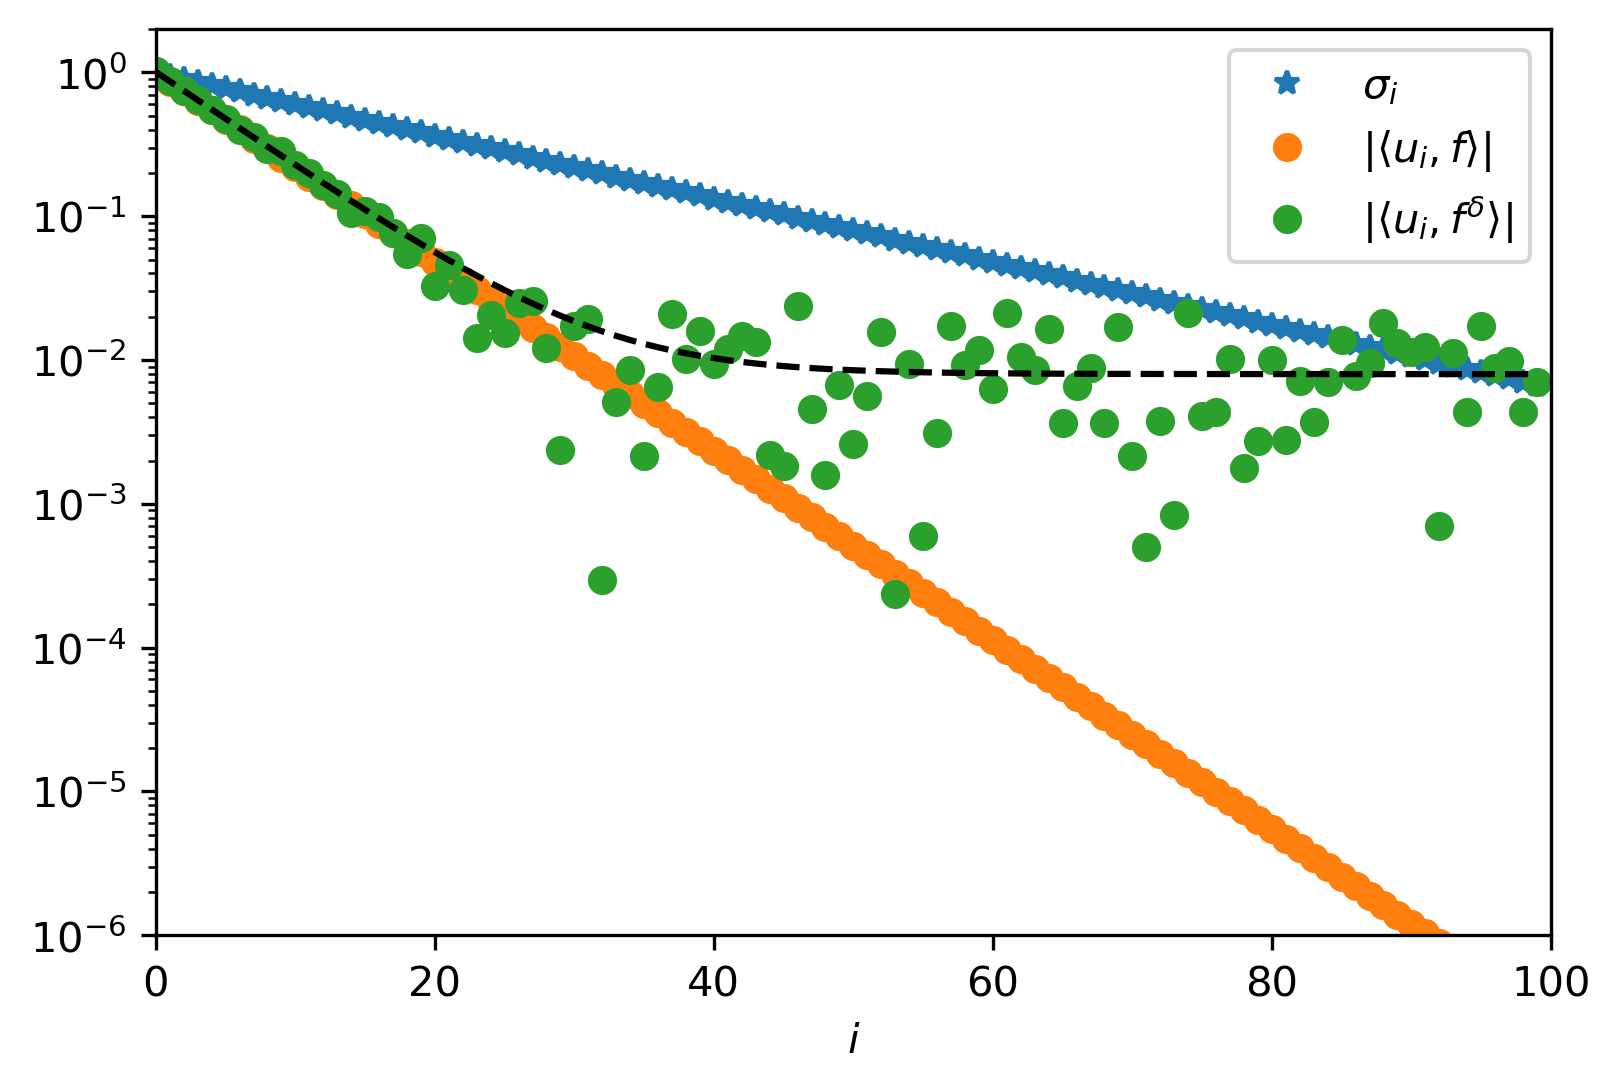

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# define forward operator
def getK(n):
    x = np.linspace(0,1,n)
    K = np.diag(np.exp(-5*x))

    return K,x

# parameters
n = 100
sigma = 1e-2
K,x = getK(n)

# define ground truth and compute data
u = np.exp(-10*x)
f = K@u

# add noise
noise = np.random.randn(n)
f_delta = f + sigma*noise

# SVD
U, s, Vh = np.linalg.svd(K, full_matrices=True)

# apply pseudo inverse
uhat = Vh.T@np.diag(1/s)@U.T@f_delta

# plot
fig, ax = plt.subplots(1,1)

ax.semilogy(s,'*',label=r'$\sigma_i$')
ax.semilogy(np.abs(U.T@f),'o',label=r'$|\langle u_i, f\rangle|$')
ax.semilogy(np.abs(U.T@f_delta),'o',label=r'$|\langle u_i, f^{\delta}\rangle|$')
ax.semilogy(np.abs(U.T@f) + np.sqrt(2/np.pi)*sigma,'k--')
ax.set_xlabel(r'$i$')
ax.set_ylim([1e-6,2])
ax.set_xlim([0,n])
ax.legend()
plt.savefig('example1.png',dpi=300)

![](example1.png)

# Regularisation


Modify the pseudo-inverse to avoid blow-up of the solution

$$\widetilde{u} = \sum_{i=1}^k r_{\alpha}(\sigma_i)\langle u_i, f^\delta\rangle v_i,$$

with $g_{\alpha}$ such that 

$$r_0(s) = s^{-1}\quad \text{for}\quad s > 0,$$
$$r_{\alpha}(0) < \infty \quad\text{for}\quad \alpha > 0,$$
$$r_{\alpha}(s) \rightarrow 0 \quad\text{for}\quad\alpha \rightarrow \infty.$$

## Examples 

Truncated SVD: 

$$r_{\alpha}(s) = \begin{cases}s^{-1} & s > \alpha \\ 0 & \text{otherwise} \end{cases}$$


Tikhonov regularisation:

$$r_{\alpha}(s) = \frac{s}{s^2 + \alpha}$$

# Bias-variance trade-off

We study the difference between the ideal solution

$$\widetilde{u} = K^\dagger\!f,$$

and the regularised solution from noisy data

$$\widetilde{u}_{\alpha,\delta} = K_{\alpha}^\dagger\! f^\delta.$$

We can split the error in two parts

$$\|\widetilde{u} - \widetilde{u}_{\alpha,\delta}\| \leq \|(K^\dagger - K_{\alpha}^\dagger)f\| + \|K_{\alpha}^\dagger (f - f^\delta)\|,$$

that we refer to as the 

* *bias*: goes to zero as $\alpha \rightarrow 0$
* *variance*: goes to zero as $\alpha \rightarrow \infty$

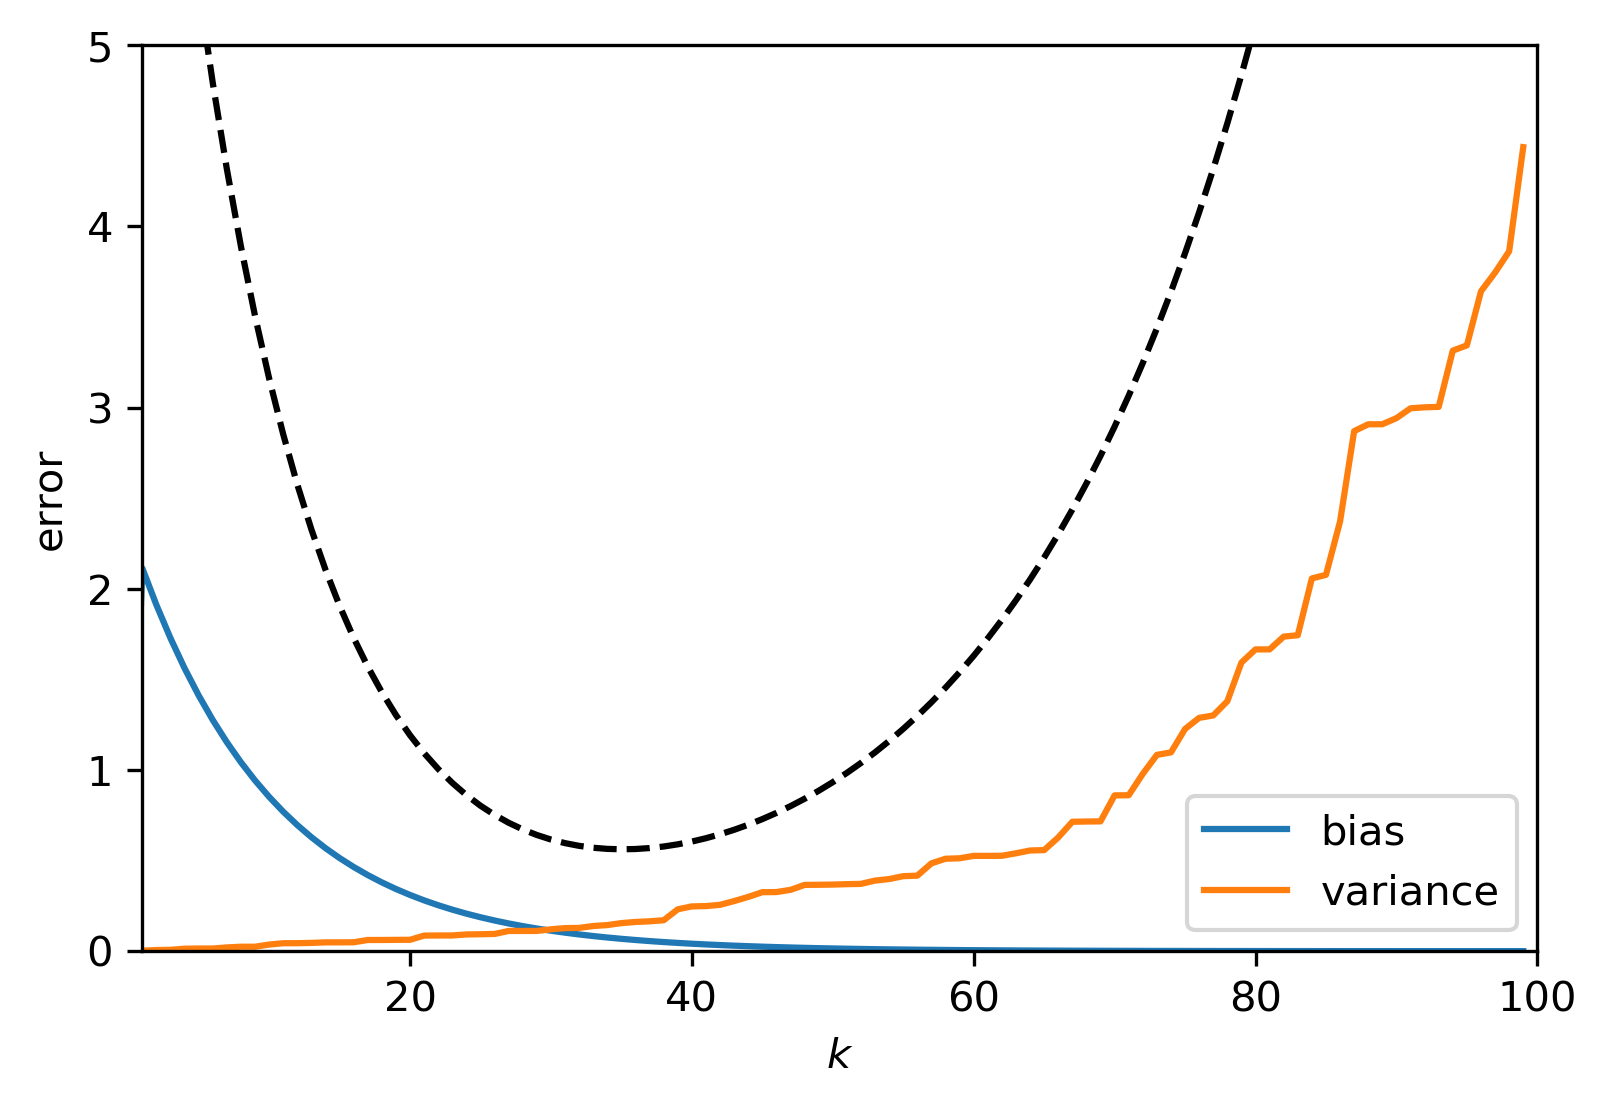

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# define forward operator
def getK(n):
    x = np.linspace(0,1,n)
    K = np.diag(np.exp(-5*x))

    return K,x

# parameters
n = 100
sigma = 1e-2
K,x = getK(n)

# define ground truth and compute data
u = np.exp(-10*x)
f = K@u

# add noise
noise = np.random.randn(n)
f_delta = f + sigma*noise

# SVD
U, s, Vh = np.linalg.svd(K, full_matrices=True)

# error, bias and variance for TSVD
error = np.zeros(n)
bias = np.zeros(n)
variance = np.zeros(n)

for k in range(1,n):
    uk = Vh[:k,:].T@np.diag(1/s[:k])@U[:,:k].T@f
    uk_delta = Vh[:k,:].T@np.diag(1/s[:k])@U[:,:k].T@f_delta

    error[k] = np.linalg.norm(u - uk_delta)
    bias[k] = np.linalg.norm(u - uk)
    variance[k] = np.linalg.norm(uk - uk_delta)

# plot
k = np.linspace(0,n-1,n)

fig, ax = plt.subplots(1,1)

ax.plot(k,bias,label='bias')
ax.plot(k,variance,label='variance')
ax.plot(k,np.exp(5*k/(n-1))*sigma*np.sqrt(k+1) + np.exp(-10*(k+1)/(n-1))*np.sqrt(n-k-1),'k--')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'error')
ax.set_xlim([1,n])
ax.set_ylim([0,5])
ax.legend()
plt.savefig('example2.png',dpi=300);

![](example2.png)

# A Variational formulation


We have seen the connection between the pseudo-inverse and the least-squares problem

$$\min_u \|Ku - f^\delta\|_2^2.$$

Tikhonov regularisation can be formulated as 

$$\min_u \|Ku - f\|_2^2 + \alpha \|u\|_2^2.
$$

# Summary


* Direct (regularised) solution of linear inverse problem through SVD / (regularised) pseudo inverse
* Instability is caused by interplay between spectrum of $K$ and Fourier coefficients of noise
* We need to balance regularisation strength and noise level
* Tikhonov regularisation through the SVD has a variational counter part

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

def plot_results(u,delta,alpha):
    # blur
    psf = np.ones((5, 5)) / 25
    f = conv2(u, psf, 'same')

    # Add Noise to Image
    f_delta = f.copy()
    f_delta += delta*np.random.normal(size=u.shape)

    # Restore Image 
    u_hat = restoration.wiener(f_delta, psf, balance=alpha)

    # plot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    plt.gray()

    for a in (ax[0,0], ax[0,1], ax[1,0], ax[1,1]):
           a.axis('off')

    ax[0,0].imshow(u, vmin = 0.0, vmax = 1.0)
    ax[0,0].set_title(r'$u$')

    ax[0,1].imshow(f, vmin = 0.0, vmax = 1.0)
    ax[0,1].set_title(r'$f$')
    
    ax[1,1].imshow(f_delta, vmin = 0.0, vmax = 1.0)
    ax[1,1].set_title(r'$f^\delta$')

    ax[1,0].imshow(u_hat, vmin = 0.0, vmax = 1.0)
    ax[1,0].set_title(r'$K_{\alpha}^\dagger f^\delta$')


    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                        top=0.9, bottom=0.05, left=0, right=1)
    plt.show()

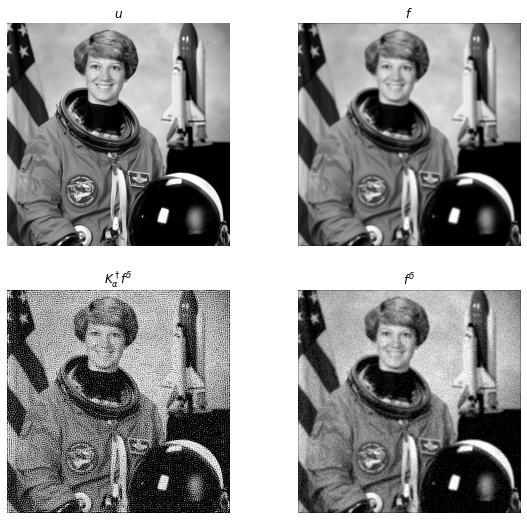

In [17]:
astro = color.rgb2gray(data.astronaut())
plot_results(astro,delta = 1e-1,alpha = 1e-3)